In [201]:
import sys
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
import genml

sys.path.append('..')
from src.kernels import exp_kernel, complex_exp_kernel, complex_discrete_kernel
from src.probability import Distribution, xi_frac
from src.spectral_transforms import psi_real_to_circle, psi_inv_circle_to_real, B_real, B_circle, B_reg, mobius_inv
from src.numerical import trap_quad, trap_quad_gen, fourier_quad, conv_trap, conv_fourier, volterra_cm_numerical_inversion, volterra_pd_numerical_inversion
from src.plotting import plot_real_distribution, plot_circle_distribution_3D, plot_discrete
from src.hilbert_transform import HilbertTransform

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=8)
plt.rcParams.update({
    'font.size': 8,
    'text.usetex': True,
    'text.latex.preamble': r"\usepackage{amsfonts}" + "\n" + r"\usepackage{amsmath}" + "\n" + r"\usepackage{amssymb}"
})

In [202]:
t = np.linspace(0, 10, int(1e4))
dt = t[1] - t[0]

density = lambda s: np.sqrt(s * (s >= 0))/np.pi
atoms = np.array([])
atom_wts = np.array([])

pts = np.concatenate((-np.flip(np.logspace(1, 3, int(1e3))), np.linspace(-10, 10, int(1e4))[1:-1], np.logspace(1, 3, int(1e3))))
quad_pts, quad_wts = trap_quad_gen(pts)
lmbda = Distribution(density, atoms, atom_wts, quad_pts, quad_wts, full_support=True)
c0 = 0
c1 = 1

K = 1/np.sqrt(np.pi*t)
K[~np.isfinite(K)] = 0

xi = (1/(np.pi*np.sqrt(2)))
mu, zeta0, zeta1 = B_reg(lmbda, c0-np.pi*xi, c1)

J_spectral = exp_kernel(mu, t)

alpha = 1/2
a = -1
J = np.pi**2/(np.abs(a)*dt**alpha) * genml.acft(len(t)-1, 1, 1, alpha, np.abs(a)**(-1/alpha)/dt)

/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_99392/1737064619.py:14: RuntimeWarning: divide by zero encountered in divide
  K = 1/np.sqrt(np.pi*t)


AAA failed to converge within 200 iterations.


/Users/georgestepaniants/Research/time-deconvolution/experiments/../src/hilbert_transform.py:196: RuntimeWarning: divide by zero encountered in divide
  self.H_disc = lambda x: np.sum(self.lmbda.atom_wts[None, :] / np.tan((x[:, None] - self.lmbda.atoms[None, :])/2), axis=1)
/Users/georgestepaniants/Research/time-deconvolution/experiments/../src/kernels.py:13: RuntimeWarning: overflow encountered in exp
  kernel += np.sum(lmbda.quad_wts[inds]*(-lmbda.quad_pts[inds])**deriv_order*lmbda.density_vals[inds]*np.exp(-lmbda.quad_pts[inds]*t[:, None]), axis=1)
/Users/georgestepaniants/Research/time-deconvolution/experiments/../src/kernels.py:13: RuntimeWarning: invalid value encountered in multiply
  kernel += np.sum(lmbda.quad_wts[inds]*(-lmbda.quad_pts[inds])**deriv_order*lmbda.density_vals[inds]*np.exp(-lmbda.quad_pts[inds]*t[:, None]), axis=1)


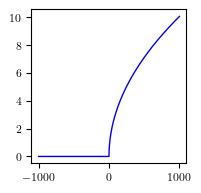

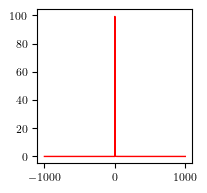

In [203]:
fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, lmbda, color="blue")
plt.show()

fig, ax = plt.subplots(figsize=(2, 2))
plot_real_distribution(ax, mu, color="red")
plt.show()

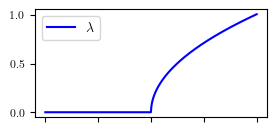

/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_99392/4155273736.py:13: RuntimeWarning: invalid value encountered in sqrt
  mu_true = lambda s: np.pi/(s**(1/2) + s**(3/2))
/var/folders/pw/wkdn0vxs0b54swhpwjg6s0x00000gn/T/ipykernel_99392/4155273736.py:13: RuntimeWarning: invalid value encountered in power
  mu_true = lambda s: np.pi/(s**(1/2) + s**(3/2))


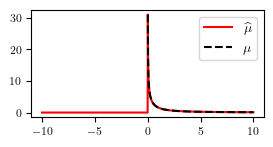

In [204]:
fig, ax = plt.subplots(figsize=(3, 1.4))
s = np.linspace(-10, 10, 1000)
ax.plot(s, lmbda.density(s), color="blue", label=f"$\lambda$")
ax.set_xticklabels([])
#ax.set_title("Spectral Distribution Inversion", size=12)
plt.legend(fontsize=10)
#plt.savefig(f"../figures/fractional_distribution_lambda.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

fig, ax = plt.subplots(figsize=(3, 1.4))
s = np.linspace(-10, 10, 1000)
ax.plot(s, mu.density(s), color="red", label=f"$\widehat\mu$")
mu_true = lambda s: np.pi/(s**(1/2) + s**(3/2))
ax.plot(s, mu_true(s), color="black", linestyle="--", label=f"$\mu$")
plt.legend(fontsize=10)
#plt.savefig(f"../figures/fractional_distribution_mu.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

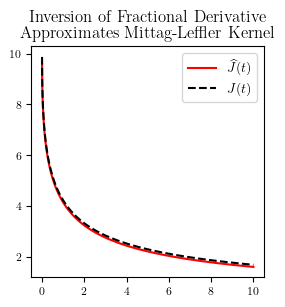

In [215]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(t, J_spectral, color="red", label="$\widehat{J}(t)$")
ax.plot(t, J, color="black", linestyle="--", label="$J(t)$")
#ax.set_xlim([0, 0.1])
ax.set_title("Inversion of Fractional Derivative\n Approximates Mittag-Leffler Kernel", size=12)
plt.legend(fontsize=10)
#plt.savefig(f"../figures/fractional_kernel_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()

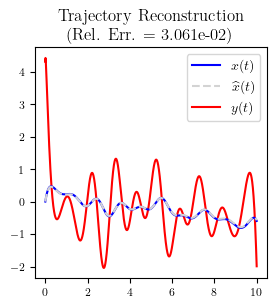

In [216]:
n_interp = 20
np.random.seed(1)
T = t[-1]
interp_ys = np.cumsum(np.insert(np.random.randn(n_interp), 0, 0))/np.sqrt(n_interp)
interp_ts = np.linspace(0, T, n_interp+1)
cs = scipy.interpolate.make_interp_spline(interp_ts, interp_ys, k=5)
x = cs(t)

xdot = np.gradient(x, dt)

y = c1*xdot - c0*x + np.gradient(conv_trap(K, x, t), dt)

#x_true = conv_trap(J, y, t)/np.pi**2
x_hat = conv_trap(J_spectral, y, t)/np.pi**2

rel_err = np.linalg.norm(x_hat - x) / np.linalg.norm(x)

fig, ax = plt.subplots(figsize=(3, 3))
ax.plot(t, x, color="blue", zorder=3, label="$x(t)$")
#ax.plot(t, x_true, color="blue", zorder=3, label="$x_true(t)$")
ax.plot(t, x_hat, linestyle='--', zorder=4, color="lightgray", label="$\widehat{x}(t)$")
ax.plot(t, y, color="red", label="$y(t)$")
ax.set_title(f"Trajectory Reconstruction\n(Rel. Err. = {rel_err:.3e})", size=12)
plt.legend(fontsize=10)
#plt.savefig(f"../figures/fractional_data_inversion.pdf", bbox_inches='tight', pad_inches=0.08)
plt.show()